# Home Assignemet 2

- Diogo Araújo - fcXXXXX -YH
- João Braz - fcXXXXX - YH
- Joel Oliveira - fc59442 - 7 H

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from time import time
from pyfim import pyeclat
from PD_freqitems import freqitemsets
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import (apriori, association_rules,
                                       fpgrowth, fpmax)

In [2]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
#we subtract 1 because the pids start at 1, the first 0 is never filled
#therefore the product with pid {pid} is at index {pid}-1
products=[0]* (len(lines)-1)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid) - 1]=pname
#read transactions
orders=pickle.load(open("order_products.pickle", "rb"))
#check products on order 2:
for prod in orders[6]: print(products[prod-1])

Cleanse
Dryer Sheets Geranium Scent
Clean Day Lavender Scent Room Freshener Spray


In [3]:
def index_to_product(index):
    return products[index]
def sequence_of_index_to_products(sequence):
    return [index_to_product(i) for i in sequence]

In [4]:
len(orders),len(products),len(orders)*len(products)

(3214874, 49688, 159740659312)

## Objective 1 - Analyze the itemset/rules generation procedure

In [5]:
order_list = orders.values()
order_list = [list(map(lambda x: x-1, order)) for order in order_list]

In [6]:
encoder = TransactionEncoder().fit(order_list)
binary_orders = encoder.transform(order_list, sparse=True)
binary_orders = pd.DataFrame.sparse.from_spmatrix(binary_orders, columns=encoder.columns_)

##  From the approaches used in classes make a performance analysis up to a threshold level of support
Approaches considered in class:
 1. Apriori
 2. Fp-Growth
 3. ECLAT
 4. Naive

In [7]:
results = pd.DataFrame(columns = ["threshold", "n_itemsets", "apriori", 
                                  "fp-growth", "eclat", "naive"])

In [8]:
#threshold values to explore
thresholds = [0.03, 0.02, 0.01, 0.009, 0.007, 0.005, 0.003, 0.001,]
#buffer to store time results of each fqi function;
results_list = [[np.nan for _ in range(len(thresholds))] for __ in range(4)]
#max number of iterations for each fqi function 
#(crash limits found or values where the methods have beend surpassed)
caps = [3, float('inf'), 7, 6 ]

In [9]:
func = [apriori, fpgrowth, pyeclat, freqitemsets]
data = [binary_orders, order_list]

In [16]:
# performed each algorithm once at a time because of memory limitations ( 16GB ) 
#index for the data source in the list {data}
data_index = 1
#index for the fqi function in the list {func}
func_index = 3
for i,thresh in enumerate(thresholds):
    if i>caps[func_index]:
        break
    start = time()
    fi = func[func_index](
        data[data_index], 
        thresh
    )
    stop = time() - start
    results_list[func_index][i] = stop
    results.loc[i] = {
        "threshold": thresh,
        "n_itemsets": len(fi),
        "apriori": results_list[0][i],
        "fp-growth": results_list[1][i],
        "eclat": results_list[2][i],
        "naive": results_list[3][i]
    }

When running we could verify that apriori algorithm consumes a lot more memory than any of the other 3 algorithms. With the other methods we can set the threshold value lower past $0.009$. When using apriori, any value below that one would crash the program because of insufficient memory.

<Axes: xlabel='threshold'>

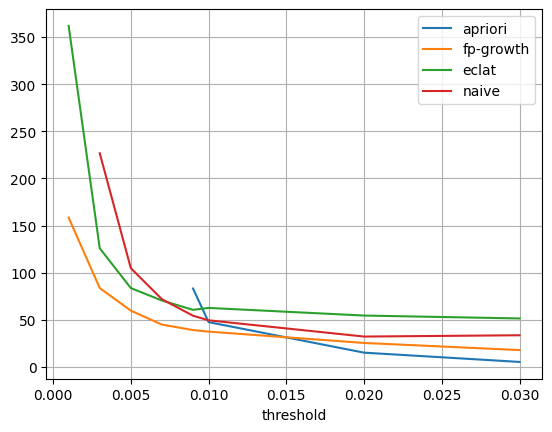

In [18]:
results.plot(x="threshold", y=["apriori", "fp-growth", "eclat", "naive"], grid=True)

We can see that *Apriori* is the one that has the better results for a bigger threshold. However the time it takes, rapidly surpasses all the other algorithms, and as we said it consumed more memory than the others too. It is not a good option, and we did not explore it beyond the support value of $0.009$ since the memory consumption was too high. <br>
*Eclat* started with a performance worse than the *'Naive'*. As we lowered the threshold it *Eclat* surpassed *'Naive'* performance.<br>
*FPGrowth* has a good trend and is better than *Eclat* and *'Naive'*, being only surpassed by apriori when the threshold value is higher.<br>

We can see that *FPGrowth* is indeed the best option.

We will now exploit the minimum threshold for the *FPGrowth* given the limits of our machine.

In [19]:
threshold=[0.0005, 0.0002, 0.0002, 0.0001]
for thresh in threshold:
    fi = fpgrowth(binary_orders, thresh)

With the threshold at $0.01\%$ the memory was surpassing the 16 GB. Therefore we will use the threshold values of $0.02\%$

## Objective 2 - Identify the most relevant rules

### 1. Generate all available itemsets and generate rules

In [21]:
thresh=0.0002
fi = fpgrowth(binary_orders, thresh)

### 2. Identify a set of relevant rules and comment them

In [22]:
def print_rule(rules, index):
    for item in sequence_of_index_to_products(rules.loc[index, "antecedents"]):
        print(item)
    print("==>")
    for item in sequence_of_index_to_products(rules.loc[index, "consequents"]):
        print(item)

We will filter the rules by *confidence*, with a threshold value of $50\%$.

In [23]:
rules = association_rules(
    fi,
    metric="confidence", 
    min_threshold=0.6
)
rules.shape

(85, 9)

In order to reduce the number of rules to a feasible number we will filter the rules so that it contains only elements with the higher lift values and higher conviction values.

In [24]:
promissing_rules = rules[ rules.lift>=rules.lift.quantile(0.75) ]
promissing_rules.shape

(22, 9)

We reduced the set of rules to the ones with the most relevant statistcs, namely high *Confidence* and a high *Lift*. <br>
We'll sample some of the rules to inspect them.

[comment]: <> (We can see that the rules *$54, 55, 57$* are similar. This could indicate that the itemset that leads to purchasing product $28459$ is some subset of those antecedents.)

In [25]:
promissing_rules.sort_values(by="lift", ascending=False).iloc[:5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
80,"(6505, 13265)",(44777),0.000381,0.000707,0.000239,0.625612,885.238968,0.000238,2.669136
79,"(44777, 6505)",(13265),0.000306,0.000889,0.000239,0.779472,877.109836,0.000238,4.530532
78,(44777),(13265),0.000707,0.000889,0.000467,0.661092,743.901307,0.000467,2.948027
82,"(37746, 4806)",(41798),0.000326,0.001308,0.000205,0.627863,479.909447,0.000204,2.683664
71,"(38304, 48209, 31629)",(15980),0.000298,0.001467,0.000204,0.685089,467.021552,0.000204,3.170838


From the table above we can see that there a set of rules that stand out, from the *lift* statistic. <br>

Comparing the ***first*** and ***second*** rules (sorted by lift) we can see that they were built from the same *set*. The ***second*** rules has a higher *conviction* value, with almost the same *lift*. It also has a higher *confidence*. To our eyes, the ***second*** rule is the one that stands out between these two. <br>

The ***third*** rule is built from a subset of the previous one. We can see that the *support* from this rule is almost $2$ times the *support* of the ***second*** rule. It seems logic that product $44777$ is highly related to product $13265$. This rule also seems very promissing. <br>
Similar logic can be applied to study the other rules.

We will print some of the rules with highest lift.

In [26]:
index = [80, 79, 78, 82, 71]
for i, idx in enumerate(
    index, 
    start=1
):
    print(f"--- Association Rule #{i} --- Lift = \
{promissing_rules.loc[idx, 'lift']:.2f} ---")
    print_rule(promissing_rules, idx)
    print()

--- Association Rule #1 --- Lift = 885.24 ---
Snacks Sharp Cheddar Sticks Cheese
Manchego
==>
Giant Chocolate Cookies & Cream Ice Cream Bars

--- Association Rule #2 --- Lift = 877.11 ---
Giant Chocolate Cookies & Cream Ice Cream Bars
Snacks Sharp Cheddar Sticks Cheese
==>
Manchego

--- Association Rule #3 --- Lift = 743.90 ---
Giant Chocolate Cookies & Cream Ice Cream Bars
==>
Manchego

--- Association Rule #4 --- Lift = 479.91 ---
Green Writing Gel
Breaded Chicken Patties
==>
Unscented Glycerine Soap

--- Association Rule #5 --- Lift = 467.02 ---
Extra Sweet Iced Tea
Whole Wheat Blueberry Fig Bars
Pepperoncini Potato Chips
==>
Unsweetened Soymilk



*(This analysis was made with the help o **ChatGPT**)* <br>
***Rule #1 / #2 / #3*** - *Manchego* can be used as a desert, or has a snack. *Giant Chocolate Cookies & Ice Cream Bars* is also a desert, or a mid-afternoon snack. This items are likely bought for gathering events of some kind. <br>
***Rule #4*** - We can't find any logical relation for this rule. <br>
***Rule #5*** - The items themselves don't seem to have a clear relation. Maybe someone that is trying to start a diet or a change in their meals but still need <br>

This is actually a hard step, to interpret the results. Even in our comments, we can't actually know if they are accurate with out some proper study.

### 3. Identify the Maximal and Closed Itemsets for the same level of support
- Closed itemsets are a subset of the all the frequent itemsets
- Maximal itemsets are a subset of the Closed itemsets

In [59]:
def get_closed_itemset(fi):
    set_size = fi.itemsets.apply(len)
    min_set_size, max_set_size = set_size.min(), set_size.max()
    closed_fi = pd.DataFrame(columns=["support", "itemsets"])
    for size in range(min_set_size, max_set_size+1):
        sets = fi[set_size==size]
        super_sets = fi[set_size==size+1]
        for i in sets.index:
            row = sets.loc[i]
            itemset = row.itemsets
            matching_supersets = super_sets[
                super_sets.itemsets.apply(lambda item: (itemset&item) == itemset)
            ]
            if (len(matching_supersets)==0) or \
            (matching_supersets.support!=row.support).all():
                closed_fi.loc[i] = row                      
    return closed_fi

In [60]:
def get_maximal_itemset(fi):
    set_size = fi.itemsets.apply(len)
    min_set_size, max_set_size = set_size.min(), set_size.max()
    max_fi = pd.DataFrame(columns=["support", "itemsets"])
    for size in range(min_set_size, max_set_size+1):
        sets = fi[set_size==size]
        super_sets = fi[set_size==size+1]
        for i in sets.index:
            row = sets.loc[i]
            itemset = row.itemsets
            matching_supersets = super_sets[
                super_sets.itemsets.apply(lambda item: (itemset&item) == itemset)
            ]
            if len(matching_supersets)==0:
                max_fi.loc[i] = row
    return max_fi

In [27]:
fi_closed = get_closed_itemset(fi)
fi.shape, fi_closed.shape

((39492, 2), (39492, 2))

It seems that all the *frequent itemsets* previously generated are actually *closed frequent itemsets*.

In [28]:
fi_max = get_maximal_itemset(fi_closed)
fi_closed.shape, fi_max.shape

((39492, 2), (32597, 2))

### 4.Generate the most relevant rules for closed and maximal itemsets

Like it was said, the *frequent itemsets* generated for the support value threshold of $0.02\%$ were already closed itemsets. Therefore the most relevant rules for the close itemset have already been generated. <br>

We need to get the rules from the *max. itemsets*. We just need to process the rules that were generated previously, filtering the rules that use itemsets from the *maximal frequent itemsets*

In [29]:
def filter_rules_by_itemset(rules, fi):
    rule_filter = [False for _ in range(len(rules))]
    sets_in_rules = list(map(
        lambda ant, con: ant|con, 
        rules["antecedents"], 
        rules["consequents"])
    )
    for i, set_ in enumerate(sets_in_rules):
        if  (fi.itemsets.apply(lambda itemset: set_==itemset)).any():
            rule_filter[i]=True
    return rules[rule_filter]

In [30]:
print("Total Nº of rules =", rules.shape[0])
max_itemset_rules = filter_rules_by_itemset(rules, fi_max)
print("Maximal Itemset Nº of Rules =", max_itemset_rules.shape[0])

Total Nº of rules = 85
Maximal Itemset Nº of Rules = 52


In [31]:
promissing_max_itemset_rules = max_itemset_rules[
    max_itemset_rules.lift > max_itemset_rules.lift.quantile(0.75)
]

In [32]:
promissing_max_itemset_rules.shape

(13, 9)

In [33]:
promissing_max_itemset_rules.sort_values(by="lift", ascending=False).iloc[:5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
80,"(6505, 13265)",(44777),0.000381,0.000707,0.000239,0.625612,885.238968,0.000238,2.669136
79,"(44777, 6505)",(13265),0.000306,0.000889,0.000239,0.779472,877.109836,0.000238,4.530532
82,"(37746, 4806)",(41798),0.000326,0.001308,0.000205,0.627863,479.909447,0.000204,2.683664
71,"(38304, 48209, 31629)",(15980),0.000298,0.001467,0.000204,0.685089,467.021552,0.000204,3.170838
84,"(35627, 33923)",(23287),0.000341,0.001449,0.000226,0.663014,457.699270,0.000225,2.963181


We can see that the table above is very much similar to the one generated for all the *frequent itemsets*, with only one difference ( for this small top 5 ). As we said before, the **rule #3 from the last table was a subset of the 'rule #2'**. Therefore, it is not present in the maximal frequent itemsets, nor the respective rules.

In [34]:
index = [80, 79, 82, 71, 84]
for i, idx in enumerate(
    index, 
    start=1
):
    print(f"--- Association Rule #{i} --- Lift = \
{promissing_max_itemset_rules.loc[idx, 'lift']:.2f} ---")
    print_rule(promissing_max_itemset_rules, idx)
    print()

--- Association Rule #1 --- Lift = 885.24 ---
Snacks Sharp Cheddar Sticks Cheese
Manchego
==>
Giant Chocolate Cookies & Cream Ice Cream Bars

--- Association Rule #2 --- Lift = 877.11 ---
Giant Chocolate Cookies & Cream Ice Cream Bars
Snacks Sharp Cheddar Sticks Cheese
==>
Manchego

--- Association Rule #3 --- Lift = 479.91 ---
Green Writing Gel
Breaded Chicken Patties
==>
Unscented Glycerine Soap

--- Association Rule #4 --- Lift = 467.02 ---
Extra Sweet Iced Tea
Whole Wheat Blueberry Fig Bars
Pepperoncini Potato Chips
==>
Unsweetened Soymilk

--- Association Rule #5 --- Lift = 457.70 ---
Organic Strawberry Smoothie
Soft-Picks  - 40 CT
==>
Distilled Water



The top 4 rules have been commented previously.<br>
(With the help of ***ChatGPT***) <br>
**Rule #5** - Distilled water is used majorly for cleaning. Soft picks are used for dental cleaning. Smoothies are items 